<style>
h3.indent {
    margin-left: 20px; /* ajusta este valor para más o menos sangría */
}
</style>

# Laboratorio 4
### Análisis de modelos usando datos geospaciales.

**Integrantes:**  
* Francis Aguilar 22243 
* Angela García 22869
* César López 22404

enlace al repositorio: 
https://github.com/faguilarleal/lab4_ds


# Resolviendo ejercicio de la practica: 

1. Muestre el mapa en true color del lago de Amatitlan.  
2. Calcule los índices NDVI y NDWI para el lago de amatitlán y muestre los mapas.  
3. Discuta semejanzas y diferencias sobre los índices en ambos lagos

In [18]:
#!pip install openeo
#!pip install rasterio

In [16]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

In [17]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [18]:
lago_amatitlan = {
"west": -90.638065,
"east": -90.512924,
"south": 14.412347,
"north": 14.493799
}


In [20]:
amatitlan_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=lago_amatitlan,  # Región de Guatemala
    temporal_extent=["2025-02-07", "2025-02-07"],  # Usa fechas pasadas, no futuras
    bands=["B02","B03","B04", "B08"]
)

In [19]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [25]:
result_graph = amatitlan_cube.save_result(format="GTIFF")
job = connection.create_job(result_graph)
job.start_and_wait()
job.download_results("imgs/Bandas_Amatitlan_try_2.tiff")

0:00:00 Job 'j-2508112327364ab3a033d0d9f71bc08b': send 'start'
0:00:14 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:19 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:26 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:34 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:00:44 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:00:56 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:01:12 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:01:31 Job 'j-2508112327364ab3a033d0d9f71bc08b': finished (progress 100%)


C:\Users\MSI\AppData\Local\Temp\ipykernel_18604\2298015516.py:4: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results("imgs/Bandas_Amatitlan_try_2.tiff")


{WindowsPath('imgs/Bandas_Amatitlan_try_2.tiff'): {'bands': [{'eo:center_wavelength': 0.4924,
    'eo:common_name': 'blue',
    'name': 'B02'},
   {'eo:center_wavelength': 0.5598, 'eo:common_name': 'green', 'name': 'B03'},
   {'eo:center_wavelength': 0.6646, 'eo:common_name': 'red', 'name': 'B04'},
   {'eo:center_wavelength': 0.8328, 'eo:common_name': 'nir', 'name': 'B08'}],
  'eo:bands': [{'center_wavelength': 0.4924,
    'common_name': 'blue',
    'name': 'B02'},
   {'center_wavelength': 0.5598, 'common_name': 'green', 'name': 'B03'},
   {'center_wavelength': 0.6646, 'common_name': 'red', 'name': 'B04'},
   {'center_wavelength': 0.8328, 'common_name': 'nir', 'name': 'B08'}],
  'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-2508112327364ab3a033d0d9f71bc08b/results/assets/ZTAwODlhNTctNTQyMC00YTIwLWEzMGItYjhjNzA5ZTA1ZDEw/8422c632b151a9a109c57c307e75f4f7/openEO_2025-02-07Z.tif?expires=1755559749',
  'proj:bbox': [754570, 1594630, 768170, 1603800],
  'proj:epsg': 32615,

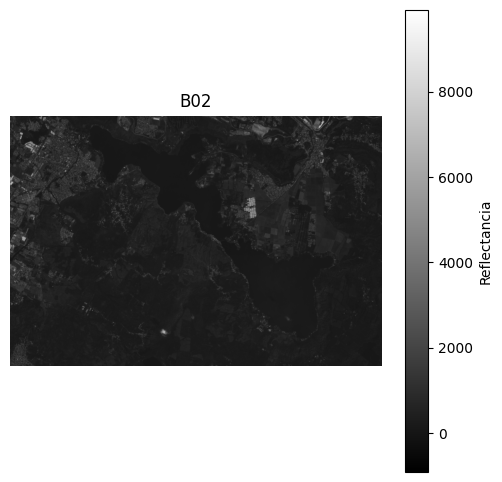

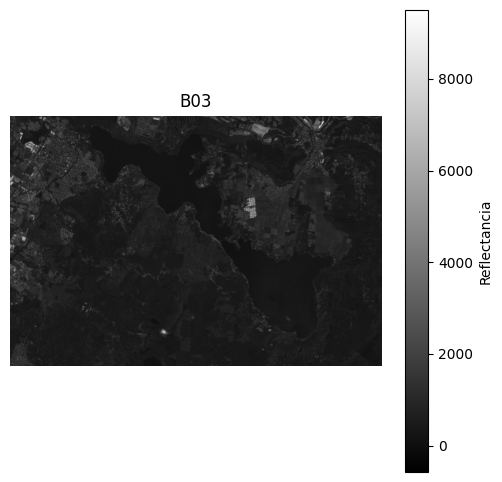

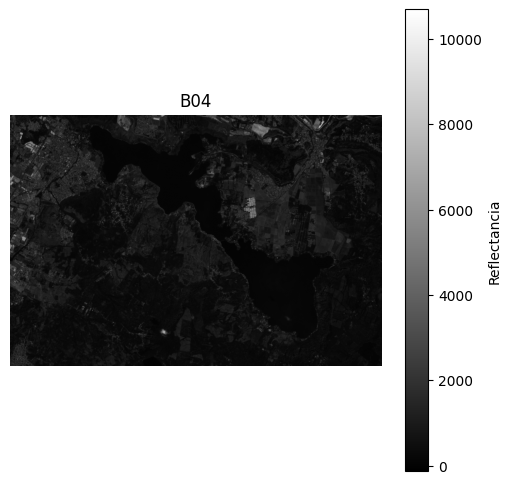

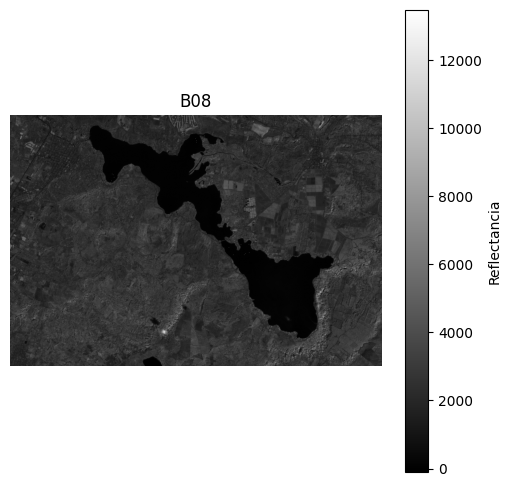

In [26]:
ruta_tif = "imgs/Bandas_Amatitlan_try_2.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

Mostrar en falso color

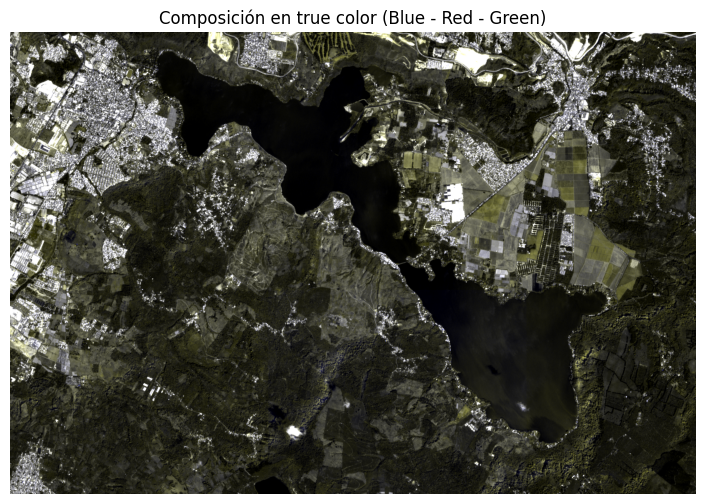

In [27]:
# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

blue = bandas[0]   #B02
green = bandas[1]  # B03
red = bandas[1]    # B04
nir = bandas[2]    # B08

# Reasignar correctamente:
b = normalize(blue)  # B02
g = normalize(green)    # B03
r = normalize(red)    # B04
n = normalize(blue)    # B08

# Falso color (NIR NearInfrared, Red, Green)
rgb = np.dstack([r, g, b])

plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Composición en true color (Blue - Red - Green)")
plt.axis('off')
plt.show()


## NDVI (Sentinel 2) = (B8 - B4) / (B8 + B4)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a float32 y escalar a reflectancia (0–1)
red_scale = red.astype(np.float32) / 10000  # B04
nir_scale = nir.astype(np.float32) / 10000  # B08
green_scale = green.astype(np.float32) / 10000  # B03
blue_scale = blue.astype(np.float32) / 10000  # B02

# Calcular NDVI
ndvi_amatitlan = np.where(
    (nir_scale + red_scale) == 0,
    0,
    (nir_scale - red_scale) / (nir_scale + red_scale)
)

ndvi_amatitlan


array([[-0.00545124, -0.00777607,  0.14308053, ..., -0.1816092 ,
        -0.1461717 ,  0.03986135],
       [ 0.03741496,  0.06760849,  0.13630228, ...,  0.0093458 ,
         0.09145132,  0.0745836 ],
       [ 0.04672896,  0.04136254,  0.10886644, ...,  0.03839543,
         0.0504396 ,  0.03209879],
       ...,
       [ 0.02259888,  0.01703578,  0.1238938 , ...,  0.04733133,
         0.09304815,  0.07304118],
       [-0.00736195,  0.14784129,  0.06709265, ...,  0.03544576,
         0.09846827, -0.02550334],
       [ 0.07979628,  0.06584045,  0.10759077, ...,  0.00910274,
         0.        , -0.06857142]], shape=(917, 1360), dtype=float32)

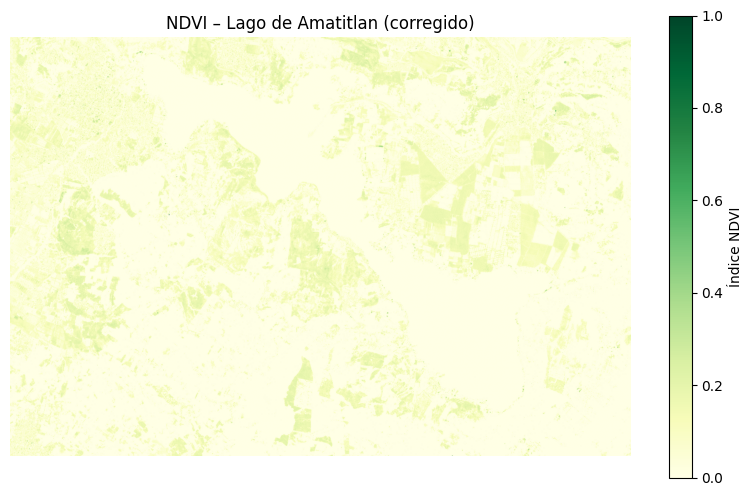

In [29]:
# Mostrar NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_amatitlan, cmap='YlGn', vmin=0, vmax=1)
plt.title("NDVI – Lago de Amatitlan (corregido)")
plt.colorbar(label="Índice NDVI")
plt.axis('off')
plt.show()

| NDVI          | Interpretación                                |
| ------------- | --------------------------------------------- |
| **0.6 a 1.0** | Vegetación muy densa y sana                   |
| **0.4 a 0.6** | Vegetación saludable (cultivos, bosques)      |
| **0.2 a 0.4** | Vegetación escasa o en estrés                 |
| **0.0 a 0.2** | Suelo desnudo, hierba seca                    |
| **< 0.0**     | Agua, nubes, nieve o superficies artificiales |


## NDWI

In [31]:
ndwi_amatitlan = np.where(
    (green + nir) == 0,
    0,
    (green - nir) / (green + nir)
)
ndwi_amatitlan

array([[ 0.00545124,  0.00777605, -0.14308053, ...,  0.1816092 ,
         0.14617169, -0.03986135],
       [-0.03741497, -0.06760848, -0.13630229, ..., -0.00934579,
        -0.09145129, -0.07458364],
       [-0.04672897, -0.04136253, -0.10886644, ..., -0.03839542,
        -0.05043961, -0.03209877],
       ...,
       [-0.02259887, -0.01703578, -0.12389381, ..., -0.04733132,
        -0.09304813, -0.07304117],
       [ 0.00736196, -0.14784126, -0.06709265, ..., -0.03544576,
        -0.09846827,  0.02550336],
       [-0.07979626, -0.06584043, -0.10759076, ..., -0.00910273,
         0.        ,  0.06857143]], shape=(917, 1360))

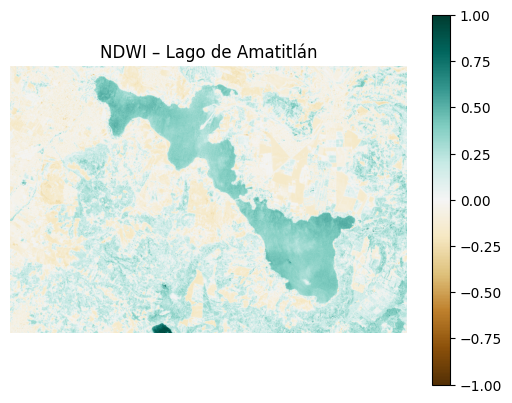

In [32]:
plt.imshow(ndwi_amatitlan, cmap='BrBG', vmin=-1, vmax=1)
plt.title("NDWI – Lago de Amatitlán")
plt.colorbar()
plt.axis('off')
plt.show()

| NDWI        | Interpretación                       |
| ----------- | ------------------------------------ |
| **> 0.2**   | Agua o zonas húmedas                 |
| **0 a 0.2** | Vegetación poco densa o suelo húmedo |
| **< 0**     | Vegetación o suelo seco              |


In [ ]:
lago_atitlan = { 
"west": -91.326256, 
"east": -91.07151, 
"south": 14.5948, 
"north": 14.750979 
} 


atitlan_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=lago_atitlan,  # Región de Guatemala
    temporal_extent=["2025-02-07", "2025-02-07"],  # Usa fechas pasadas, no futuras
    bands=["B02","B03","B04", "B08"]
    # bands=["B02", "B03", "B04", "B05", "B08", "B11", "B12"] 
)

In [41]:
result_graph = atitlan_cube.save_result(format="GTIFF")
job = connection.create_job(result_graph)
job.start_and_wait()
job.download_results("imgs/Bandas_Atitlan_try_2.tiff")

0:00:00 Job 'j-2508152341374525aa25a3922a51b04a': send 'start'
0:00:13 Job 'j-2508152341374525aa25a3922a51b04a': created (progress 0%)
0:00:18 Job 'j-2508152341374525aa25a3922a51b04a': created (progress 0%)
0:00:25 Job 'j-2508152341374525aa25a3922a51b04a': created (progress 0%)
0:00:33 Job 'j-2508152341374525aa25a3922a51b04a': running (progress N/A)
0:00:43 Job 'j-2508152341374525aa25a3922a51b04a': running (progress N/A)
0:00:55 Job 'j-2508152341374525aa25a3922a51b04a': running (progress N/A)
0:01:11 Job 'j-2508152341374525aa25a3922a51b04a': running (progress N/A)
0:01:30 Job 'j-2508152341374525aa25a3922a51b04a': running (progress N/A)
0:01:55 Job 'j-2508152341374525aa25a3922a51b04a': finished (progress 100%)


C:\Users\angel\AppData\Local\Temp\ipykernel_41964\102445502.py:4: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results("imgs/Bandas_Atitlan_try_2.tiff")
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


{WindowsPath('imgs/Bandas_Atitlan_try_2.tiff'): {'bands': [{'eo:center_wavelength': 0.4924,
    'eo:common_name': 'blue',
    'name': 'B02'},
   {'eo:center_wavelength': 0.5598, 'eo:common_name': 'green', 'name': 'B03'},
   {'eo:center_wavelength': 0.6646, 'eo:common_name': 'red', 'name': 'B04'},
   {'eo:center_wavelength': 0.8328, 'eo:common_name': 'nir', 'name': 'B08'}],
  'eo:bands': [{'center_wavelength': 0.4924,
    'common_name': 'blue',
    'name': 'B02'},
   {'center_wavelength': 0.5598, 'common_name': 'green', 'name': 'B03'},
   {'center_wavelength': 0.6646, 'common_name': 'red', 'name': 'B04'},
   {'center_wavelength': 0.8328, 'common_name': 'nir', 'name': 'B08'}],
  'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-2508152341374525aa25a3922a51b04a/results/assets/NjFjZjJjZWUtNGIwYi00M2NkLTkxOGMtMjhmODc2ODg3Y2Zh/68c4f0db6f1732e30879c722026f8f62/openEO_2025-02-07Z.tif?expires=1755906213',
  'proj:bbox': [680160, 1614170, 707750, 1631680],
  'proj:epsg': 32615,
 

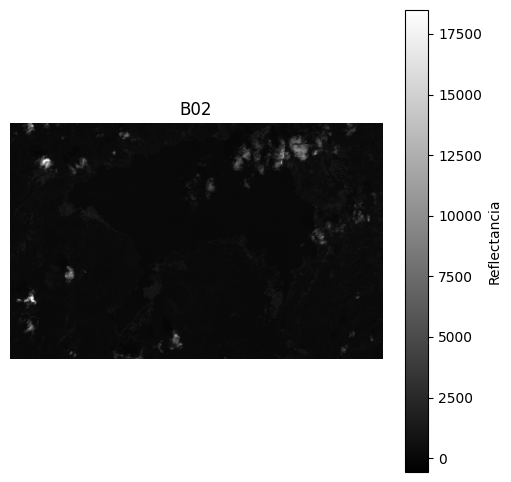

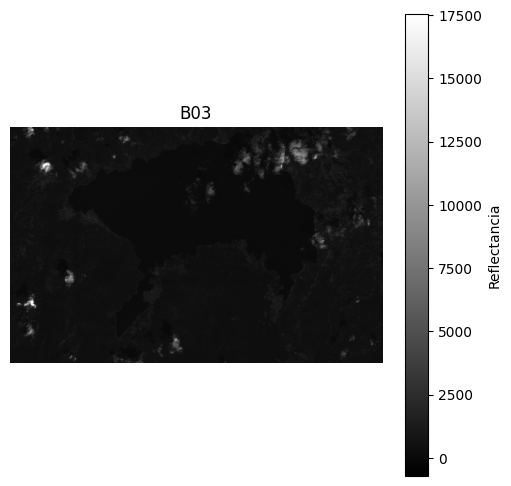

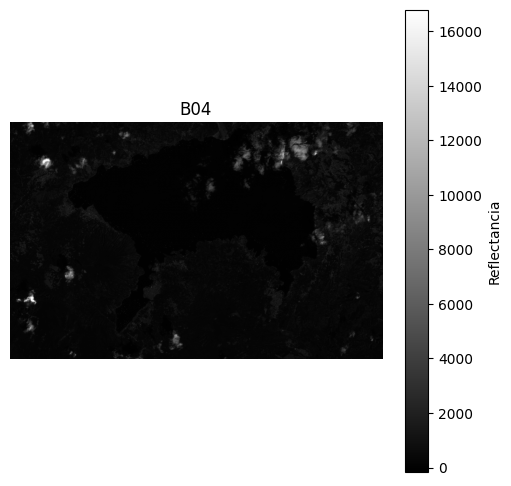

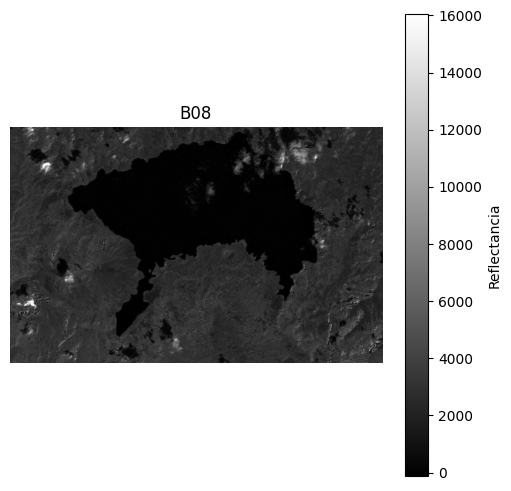

In [42]:
ruta_tif = "imgs/Bandas_Atitlan_try_2.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

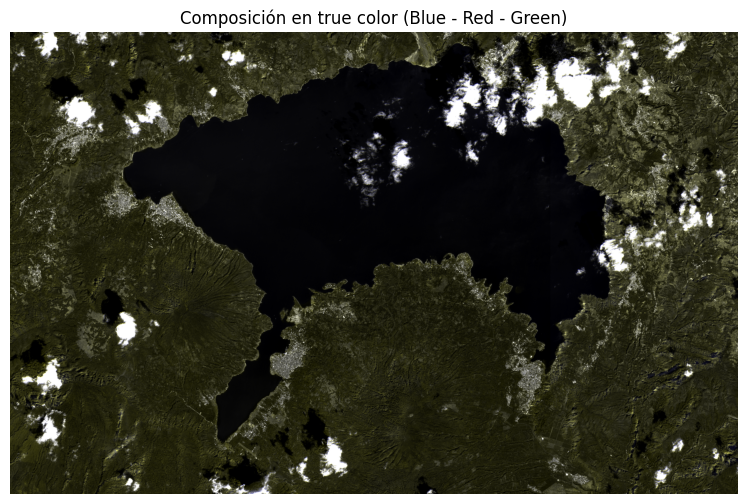

In [43]:
#mostrar en falso color
# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

blue = bandas[0]   #B02
green = bandas[1]  # B03
red = bandas[1]    # B04
nir = bandas[2]    # B08

# Reasignar correctamente:
b = normalize(blue)  # B02
g = normalize(green)    # B03
r = normalize(red)    # B04
n = normalize(blue)    # B08

# Falso color (NIR NearInfrared, Red, Green)
rgb = np.dstack([r, g, b])

plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Composición en true color (Blue - Red - Green)")
plt.axis('off')
plt.show()


## NDVI (Sentinel 2) = (B8 - B4) / (B8 + B4)

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a float32 y escalar a reflectancia (0–1)
red_scale = red.astype(np.float32) / 10000  # B04
nir_scale = nir.astype(np.float32) / 10000  # B08
green_scale = green.astype(np.float32) / 10000  # B03
blue_scale = blue.astype(np.float32) / 10000  # B02

# Calcular NDVI
ndvi_atitlan = np.where(
    (nir_scale + red_scale) == 0,
    0,
    (nir_scale - red_scale) / (nir_scale + red_scale)
)

ndvi_atitlan


C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3227356534.py:14: RuntimeWarning: divide by zero encountered in divide
  (nir_scale - red_scale) / (nir_scale + red_scale)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3227356534.py:14: RuntimeWarning: invalid value encountered in divide
  (nir_scale - red_scale) / (nir_scale + red_scale)


array([[-0.20547946, -0.15032679, -0.11894273, ..., -0.11842109,
        -0.21337578, -0.17857143],
       [-0.3628319 , -0.2238806 , -0.06493507, ...,  0.04653566,
         0.00860587, -0.17154813],
       [-0.08955226, -0.26451614, -0.16312055, ...,  0.14433752,
         0.01960783, -0.07183912],
       ...,
       [-0.15503879, -0.2057971 , -0.25925928, ..., -0.38961044,
        -0.38368577, -0.41344777],
       [-0.15706804, -0.23735407, -0.3100437 , ..., -0.4393306 ,
        -0.38418078, -0.3453537 ],
       [-0.27672035, -0.31428573, -0.31484053, ..., -0.38947368,
        -0.38360655, -0.2705249 ]], shape=(1751, 2759), dtype=float32)

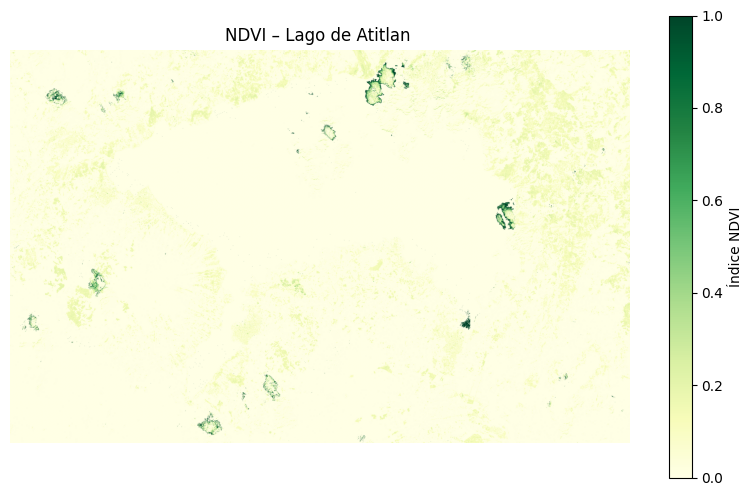

In [46]:
# Mostrar NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_atitlan, cmap='YlGn', vmin=0, vmax=1)
plt.title("NDVI – Lago de Atitlan ")
plt.colorbar(label="Índice NDVI")
plt.axis('off')
plt.show()

In [47]:
ndwi_atitlan = np.where(
    (green + nir) == 0,
    0,
    (green - nir) / (green + nir)
)
ndwi_atitlan

C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2749991595.py:4: RuntimeWarning: divide by zero encountered in divide
  (green - nir) / (green + nir)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2749991595.py:4: RuntimeWarning: invalid value encountered in divide
  (green - nir) / (green + nir)


array([[ 0.20547945,  0.1503268 ,  0.11894273, ...,  0.11842105,
         0.2133758 ,  0.17857143],
       [ 0.36283186,  0.2238806 ,  0.06493506, ..., -0.04653568,
        -0.00860585,  0.17154812],
       [ 0.08955224,  0.26451613,  0.16312057, ..., -0.14433753,
        -0.01960784,  0.07183908],
       ...,
       [ 0.15503876,  0.2057971 ,  0.25925926, ...,  0.38961039,
         0.3836858 ,  0.41344778],
       [ 0.15706806,  0.23735409,  0.31004367, ...,  0.43933054,
         0.38418079,  0.34535368],
       [ 0.27672035,  0.31428571,  0.3148405 , ...,  0.38947368,
         0.38360656,  0.2705249 ]], shape=(1751, 2759))

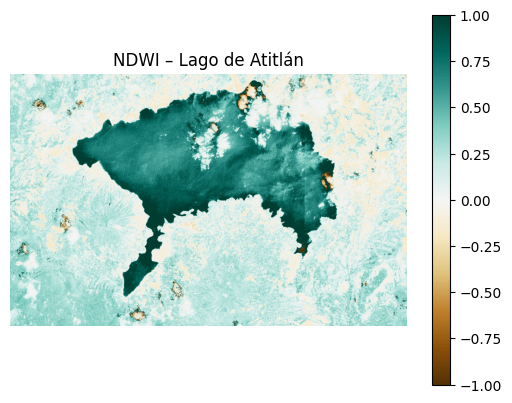

In [48]:
plt.imshow(ndwi_atitlan, cmap='BrBG', vmin=-1, vmax=1)
plt.title("NDWI – Lago de Atitlán")
plt.colorbar()
plt.axis('off')
plt.show()

# Lab 4 - Primeros Avances

In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

## &nbsp;&nbsp;Funciones

### &nbsp;&nbsp;&nbsp;&nbsp;Utils

In [22]:
from datetime import datetime, timedelta

def dict_converter(bandas, names):
    # Convierte a dict 
    out = {}
    for i, nm in enumerate(names):
        out[nm] = bandas[i]
    return out


def daily_intervals(start_date: str, end_date: str):
    start = datetime.fromisoformat(start_date)
    end   = datetime.fromisoformat(end_date)
    ivals = []
    d = start
    while d <= end:
        s = d.strftime("%Y-%m-%dT00:00:00Z")
        e = d.strftime("%Y-%m-%dT23:59:59Z")
        ivals.append([s, e])
        d += timedelta(days=1)
    return ivals

def daily_intervals(start_date: str, end_date: str):
    start = datetime.fromisoformat(start_date)
    end   = datetime.fromisoformat(end_date)
    ivals = []
    d = start
    while d <= end:
        s = d.strftime("%Y-%m-%dT00:00:00Z")
        e = d.strftime("%Y-%m-%dT23:59:59Z")
        ivals.append([s, e])
        d += timedelta(days=1)
    return ivals


### &nbsp;&nbsp;&nbsp;&nbsp;Cubo de inspeccion

In [23]:
def getCube(spatial_extent, out_dir):
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2025-01-01T00:00:00Z", "2025-06-30T23:59:59Z"],
        bands=["B02","B03","B04","B05","B07","B08","B8A"],
        max_cloud_cover=10
    )
    
    result_graph = cube.save_result(format="GTIFF")
    job = connection.create_job(result_graph)
    job.start_and_wait()
    job.download_results(out_dir)
    print(f"Descargado en : {out_dir}")


# Función para obtener las bandas de la imagen
def getBands(ruta_tiff: str): 
    with rasterio.open(ruta_tiff) as src:
        bandas = src.read()  # Lee todas las bandas
        nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
        nodata = src.nodata
    
    return bandas, nombres, nodata


# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

def getTrueColors(bandas):
    blue = bandas[0]   #B02
    green = bandas[1]  # B03
    red = bandas[2]    # B04
    nir = bandas[5]    # B08

    return  blue, green, red, nir


### &nbsp;&nbsp;&nbsp;&nbsp;Graficas

In [24]:
def NDWI_graf(ndwi, day): 
    plt.imshow(ndwi, cmap='BrBG', vmin=-1, vmax=1)
    plt.title(f"NDWI – Lago de Amatitlán en {day}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

def NDVI_graf(ndvi, day): 
    plt.figure(figsize=(10, 6))
    plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
    plt.title(f"NDVI – Lago de Amatitlán en {day}")
    plt.colorbar(label="Índice NDVI")
    plt.axis('off')
    plt.show()

# Funcion para graficar bandas de cada imagen
def bands_Graf(bandas, nombres, nodata):
    for i in range(bandas.shape[0]):
        plt.figure(figsize=(6, 6))
        img = bandas[i]
        img = np.ma.masked_where(img == nodata, img)
        plt.imshow(img, cmap='gray')
        plt.title(f"{nombres[i]}")
        plt.axis('off')
        plt.colorbar(label="Reflectancia")
        plt.show()

# Funcion para graficar imagenes en true color
def trueColors_Graph(blue, green, red): 
    b = normalize(blue)  # B02
    g = normalize(green)    # B03
    r = normalize(red)    # B04
    n = normalize(blue)    # B08

    # Falso color (NIR NearInfrared, Red, Green)
    rgb = np.dstack([r, g, b])

    plt.figure(figsize=(10, 6))
    plt.imshow(rgb)
    plt.title("Composición en true color (Blue - Red - Green)")
    plt.axis('off')
    plt.show()

### &nbsp;&nbsp;&nbsp;&nbsp;Indices

In [25]:

def getNDWI(green, nir, day):
    ndwi = np.where(
        (green + nir) == 0,
        0,
        (green - nir) / (green + nir)
    )
    print(f"Indice NDWI para {day}: {ndwi}")
    return ndwi


def getNDVI(red, nir, day):
    red_scale = red.astype(np.float32) / 10000  # B04
    nir_scale = nir.astype(np.float32) / 10000  # B08
    # Calcular NDVI
    ndvi = np.where(
        (nir_scale + red_scale) == 0,
        0,
        (nir_scale - red_scale) / (nir_scale + red_scale)
    )

    print(f"Indice NDVI para {day}: {ndvi}")

    return ndvi


### &nbsp;&nbsp;&nbsp;&nbsp;Cyanobacteria

In [26]:

# --- Cyanobacteria Chlorophyll-a NDCI L1C Evalscript pasado a python ---

# Water body detection - credit Mohor Gartner
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False

def wbi(r, g, b, nir, swir1, swir2):
    # water surface
    ws = 0
    try:
        # Calc indices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = np.power(nir, 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / np.abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0
    return ws

# Floating vegetation
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)

# Chlorophyll-a
def NDCI(a, b):
    return (b - a) / (b + a)

In [27]:
# No creo utilizarla por ahora pero estaba en el evalscript
def classify_pixel(B02, B03, B04, B05, B07, B08, B8A, B11, B12):
    water = wbi(B04, B03, B02, B08, B11, B12)
    FAIv = FAI(B04, B07, B8A)
    NDCIv = NDCI(B04, B05)
    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071

    trueColor = [3 * B04, 3 * B03, 3 * B02]

    #  Render colour map
    if water == 0:
        return trueColor
    elif FAIv > 0.08:
        return [233/255, 72/255, 21/255]
    elif chl < 0.5:
        return [0, 0, 1.0]
    elif chl < 1:
        return [0, 0, 1.0]
    elif chl < 2.5:
        return [0, 59/255, 1]
    elif chl < 3.5:
        return [0, 98/255, 1]
    elif chl < 5:
        return [15/255, 113/255, 141/255]
    elif chl < 7:
        return [14/255, 141/255, 120/255]
    elif chl < 8:
        return [13/255, 141/255, 103/255]
    elif chl < 10:
        return [30/255, 226/255, 28/255]
    elif chl < 14:
        return [42/255, 226/255, 28/255]
    elif chl < 18:
        return [68/255, 226/255, 28/255]
    elif chl < 20:
        return [68/255, 226/255, 28/255]
    elif chl < 24:
        return [134/255, 247/255, 0]
    elif chl < 28:
        return [140/255, 247/255, 0]
    elif chl < 30:
        return [205/255, 237/255, 0]
    elif chl < 38:
        return [208/255, 240/255, 0]
    elif chl < 45:
        return [208/255, 240/255, 0]
    elif chl < 50:
        return [251/255, 210/255, 3/255]
    elif chl < 75:
        return [248/255, 207/255, 2/255]
    elif chl < 90:
        return [134/255, 247/255, 0]
    elif chl < 100:
        return [245/255, 164/255, 9/255]
    elif chl < 150:
        return [240/255, 159/255, 8/255]
    elif chl < 250:
        return [237/255, 157/255, 7/255]
    elif chl < 300:
        return [239/255, 118/255, 15/255]
    elif chl < 350:
        return [239/255, 101/255, 15/255]
    elif chl < 450:
        return [239/255, 100/255, 14/255]
    elif chl < 500:
        return [233/255, 72/255, 21/255]
    else:
        return [233/255, 72/255, 21/255]


## &nbsp;&nbsp;Constantes

### Fechas y diccionarios de indices

In [167]:
DATES = [
    "2025-02-07",
    "2025-02-10",
    "2025-02-25",
    "2025-02-27",
    "2025-03-02",
    "2025-03-04",
    "2025-03-07",
    "2025-03-09",
    "2025-03-12",
    "2025-03-14",
    "2025-03-19",
    "2025-03-22",
    "2025-03-24",
    "2025-03-26",
    "2025-04-03",
    "2025-04-11",
    "2025-04-13",
    "2025-04-15",
    "2025-04-16",
    "2025-04-18",
    # "2025-04-28",
    # "2025-05-03",
    # "2025-05-13",
    # "2025-05-28",
    # "2025-07-10",
    # "2025-07-17",
    # "2025-07-20",
    # "2025-07-24",
    # "2025-08-01",
]
ndvi = {}
ndwi = {}
ndci = {}
fai  = {}


DIAS = {
    # "2025-01-06", #incompletos
    "2025-01-13",
    # "2025-01-16", #incompletoss
    "2025-01-18",
    # "2025-01-21", #incompletos
    # "2025-01-26", #incompletos
    "2025-01-28",
    # "2025-01-31", #incompletos

    # "2025-02-25", #incompletos
    # "2025-03-02", #incompletos
    "2025-03-04",
    "2025-03-09",
    "2025-03-14",
    "2025-04-13",
    "2025-04-15",
    "2025-04-18",
    "2025-05-13",


}

### Coneccion

In [29]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Coordenadas

In [30]:
lago_atitlan = {
"west": -91.326256,
"east": -91.07151,
"south": 14.5948,
"north": 14.750979
}

lago_amatitlan = {
"west": -90.638065,
"east": -90.512924,
"south": 14.412347,
"north": 14.493799
}



## &nbsp;&nbsp;Script para indices (ultimos 6 meses)

# !NO correr si ya se tienen las imagenes
a mi me tardo 33 mins xd

In [31]:

import os
import glob

# Imagenes para Amatitlan
getCube(lago_amatitlan, "imgs/Bandas_Amatitlan")
for ruta in glob.glob(os.path.join("imgs/Bandas_Amatitlan", "*.tif")):
    amatitlan_bandas, amatitlan_nombres, amatitlan_nodata = getBands(ruta)
    print(f"Archivo: {os.path.basename(ruta)}")

# Imagenes para Atitlan
getCube(lago_atitlan, "imgs/Bandas_Atitlan")
for ruta in glob.glob(os.path.join("imgs/Bandas_Atitlan", "*.tif")):
    atitlan_bandas, atitlan_nombres, atitlan_nodata = getBands(ruta)
    print(f"Archivo: {os.path.basename(ruta)}")

0:00:00 Job 'j-25081522514642ef9acab17e65d6ed12': send 'start'
0:00:13 Job 'j-25081522514642ef9acab17e65d6ed12': created (progress 0%)
0:00:18 Job 'j-25081522514642ef9acab17e65d6ed12': created (progress 0%)
0:00:25 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:00:33 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:00:43 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:00:56 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:01:11 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:01:31 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:01:55 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:02:25 Job 'j-25081522514642ef9acab17e65d6ed12': running (progress N/A)
0:03:02 Job 'j-25081522514642ef9acab17e65d6ed12': finished (progress 100%)


C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2201165517.py:13: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(out_dir)
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


Descargado en : imgs/Bandas_Amatitlan
Archivo: openEO_2025-01-08Z.tif
Archivo: openEO_2025-01-13Z.tif
Archivo: openEO_2025-01-18Z.tif
Archivo: openEO_2025-01-28Z.tif
Archivo: openEO_2025-02-02Z.tif
Archivo: openEO_2025-02-07Z.tif
Archivo: openEO_2025-03-04Z.tif
Archivo: openEO_2025-04-13Z.tif
Archivo: openEO_2025-04-15Z.tif
Archivo: openEO_2025-04-28Z.tif
0:00:00 Job 'j-250815225857466fa3104941eece8fbc': send 'start'
0:00:12 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:00:18 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:00:24 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:00:32 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:00:42 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:00:55 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:01:10 Job 'j-250815225857466fa3104941eece8fbc': queued (progress 0%)
0:01:30 Job 'j-250815225857466fa3104941eece8fbc': running (progress N/A)
0:01:54 J

----------

In [162]:
# Indices para cada dia
for day in DATES:
    # Lago Amatitlan
    ruta_amatitlan = f"imgs/Bandas_Amatitlan/day_{day}.tiff"
    amatitlan_bandas, amatitlan_nombres, amatitlan_nodata = getBands(ruta_amatitlan)
    blue, green, red, nir = getTrueColors(amatitlan_bandas)
    ndvi[f"Amatitlan - {day}"] = getNDVI(red, nir, day)
    ndwi[f"Amatitlan - {day}"] = getNDWI(green, nir, day)
    ndci[f"Amatitlan - {day}"] = NDCI(amatitlan_bandas[2], amatitlan_bandas[3])
    fai[f"Amatitlan - {day}"] = FAI(amatitlan_bandas[2], amatitlan_bandas[4], amatitlan_bandas[6])

for day in DIAS:
    # Lago Atitlan
    ruta_atitlan = f"imgs/Bandas_Atitlan/openEO_{day}Z.tif"
    atitlan_bandas, atitlan_nombres, atitlan_nodata = getBands(ruta_atitlan)
    blue, green, red, nir = getTrueColors(atitlan_bandas)
    ndvi[f"Atitlan - {day}"] = getNDVI(red, nir, day)
    ndwi[f"Atitlan - {day}"] = getNDWI(green, nir, day)
    ndci[f"Atitlan - {day}"] = NDCI(atitlan_bandas[2], atitlan_bandas[3])
    fai[f"Atitlan - {day}"] = FAI(atitlan_bandas[2], atitlan_bandas[4], atitlan_bandas[6])

Indice NDVI para 2025-02-07: [[0.10328164 0.26233023 0.50459707 ... 0.6732978  0.61928236 0.4627486 ]
 [0.0812095  0.2933264  0.47277036 ... 0.46334088 0.30973452 0.17049101]
 [0.09099459 0.21773396 0.44119182 ... 0.16617586 0.06498343 0.04453108]
 ...
 [0.11097434 0.24260357 0.33351526 ... 0.56680554 0.5432056  0.6075143 ]
 [0.06967983 0.14466494 0.10470136 ... 0.61659956 0.5647329  0.6360116 ]
 [0.08189026 0.06045703 0.07973662 ... 0.67132646 0.6846527  0.67066795]]
Indice NDWI para 2025-02-07: [[-0.15660616 -0.28156749 -0.53151665 ... -0.6370614  -0.5995671
  -0.49696233]
 [-0.09973638 -0.33191263 -0.52160913 ... -0.50817969 -0.36279926
  -0.22047852]
 [-0.16495104 -0.24974722 -0.47709617 ... -0.20574163 -0.1021632
  -0.06152242]
 ...
 [-0.11970229 -0.26298524 -0.37478897 ... -0.60802368 -0.58897418
  -0.63437926]
 [-0.13401547 -0.19447779 -0.14933837 ... -0.65033196 -0.61011804
  -0.64503569]
 [-0.13136894 -0.13393133 -0.10810811 ... -0.69022934 -0.68410853
  -0.67686129]]
Indice N

C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3299946377.py:5: RuntimeWarning: invalid value encountered in divide
  (green - nir) / (green + nir)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2923385816.py:47: RuntimeWarning: invalid value encountered in divide
  return (b - a) / (b + a)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3299946377.py:18: RuntimeWarning: divide by zero encountered in divide
  (nir_scale - red_scale) / (nir_scale + red_scale)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3299946377.py:18: RuntimeWarning: invalid value encountered in divide
  (nir_scale - red_scale) / (nir_scale + red_scale)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2923385816.py:47: RuntimeWarning: divide by zero encountered in divide
  return (b - a) / (b + a)


Indice NDVI para 2025-01-26: [[ 0.8414689   0.82317805  0.8119123  ... -0.         -0.
  -0.        ]
 [ 0.8925016   0.8338591   0.81498617 ... -0.         -0.
  -0.        ]
 [ 0.86092067  0.8252771   0.82546973 ... -0.         -0.
  -0.        ]
 ...
 [ 0.86553437  0.8784531   0.877382   ... -0.         -0.
  -0.        ]
 [ 0.8407821   0.8620451   0.86657643 ... -0.         -0.
  -0.        ]
 [ 0.8564207   0.8788066   0.86691666 ... -0.         -0.
  -0.        ]]
Indice NDWI para 2025-01-26: [[-0.75876818 -0.7662037  -0.74974773 ...  0.          0.
   0.        ]
 [-0.79145729 -0.77506361 -0.77556561 ...  0.          0.
   0.        ]
 [-0.79245283 -0.77184675 -0.76860841 ...  0.          0.
   0.        ]
 ...
 [-0.77867746 -0.79149417 -0.80127186 ...  0.          0.
   0.        ]
 [-0.74280992 -0.78412488 -0.78961039 ...  0.          0.
   0.        ]
 [-0.74635384 -0.76838448 -0.78016086 ...  0.          0.
   0.        ]]
Indice NDVI para 2025-01-16: [[ 0.8311906   0.82511216

C:\Users\angel\AppData\Local\Temp\ipykernel_41964\3299946377.py:5: RuntimeWarning: divide by zero encountered in divide
  (green - nir) / (green + nir)


Indice NDVI para 2025-01-28: [[0.8000669  0.8008734  0.8137218  ... 0.38129497 0.40605253 0.4174216 ]
 [0.83625257 0.82287186 0.80439407 ... 0.36981007 0.39313626 0.41431066]
 [0.82285994 0.8004338  0.80389607 ... 0.3464737  0.3610836  0.3673329 ]
 ...
 [0.8579235  0.8595853  0.86241746 ... 0.90096873 0.9220523  0.9202048 ]
 [0.82574767 0.82480246 0.8480854  ... 0.91024387 0.9072965  0.9083938 ]
 [0.81876194 0.8468871  0.86811996 ... 0.9193548  0.90879047 0.9083938 ]]
Indice NDWI para 2025-01-28: [[-0.71192369 -0.75788576 -0.77894737 ... -0.3656644  -0.3944591
  -0.40956341]
 [-0.77340677 -0.77183452 -0.7366985  ... -0.34047244 -0.34294137
  -0.36293306]
 [-0.77285852 -0.75290391 -0.73625    ... -0.30819868 -0.31335671
  -0.32975871]
 ...
 [-0.74780768 -0.75911906 -0.76306107 ... -0.80849974 -0.8321185
  -0.82296941]
 [-0.72269939 -0.73708306 -0.75133849 ... -0.80045977 -0.80444817
  -0.80125196]
 [-0.71583384 -0.72031077 -0.76609995 ... -0.80454928 -0.80839073
  -0.80832679]]
Indice N

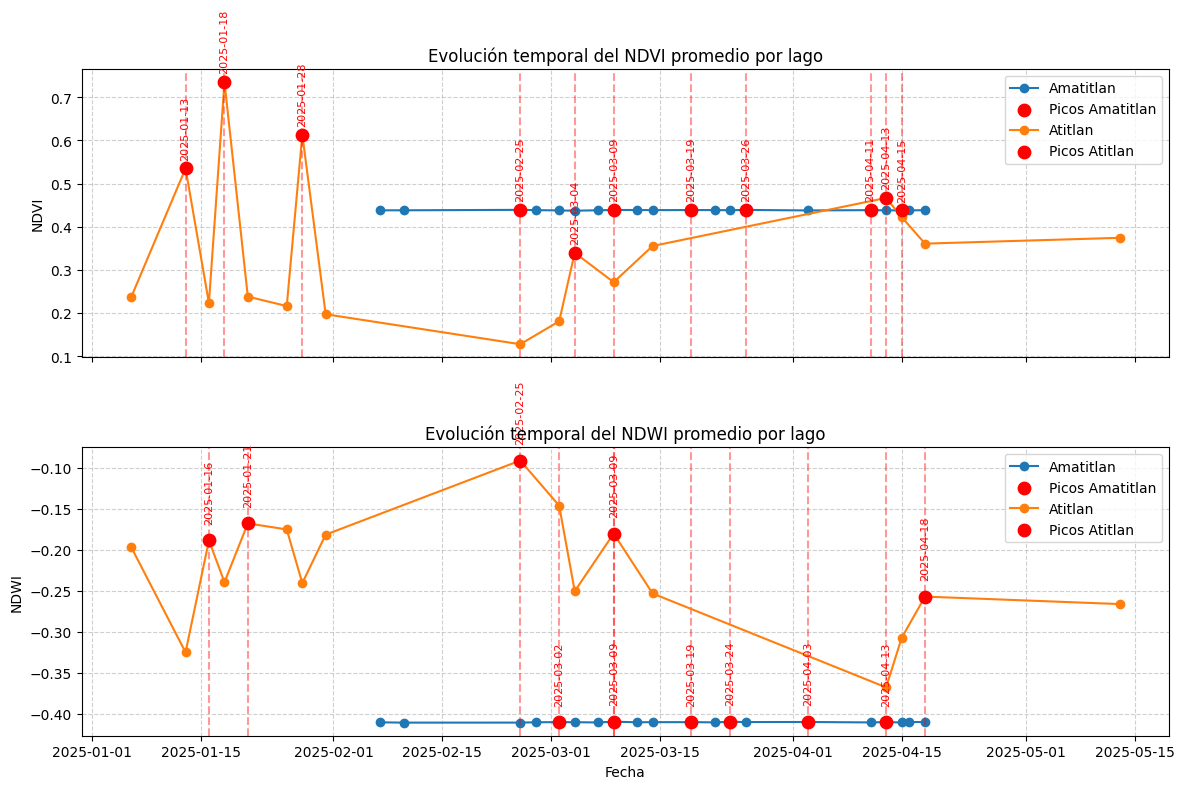

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Calcular promedios
def calcular_promedio_indices(diccionario_indices):
    promedios = []
    for clave, matriz in diccionario_indices.items():
        lago, fecha = clave.split(" - ")
        
        arr = np.array(matriz, dtype=np.float32)
        arr = np.where(np.isfinite(arr), arr, np.nan)  # eliminar inf/nan
        
        promedio = np.nanmean(arr)
        
        promedios.append({
            "Lago": lago,
            "Fecha": pd.to_datetime(fecha),
            "Promedio": promedio
        })
    
    return pd.DataFrame(promedios)

#  Calcular promedios 
df_ndvi_prom = calcular_promedio_indices(ndvi)
df_ndwi_prom = calcular_promedio_indices(ndwi)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

def plot_con_picos(ax, df, indice_nombre):
    for lago in df["Lago"].unique():
        datos = df[df["Lago"] == lago].sort_values("Fecha")
        
        # Graficar línea
        ax.plot(datos["Fecha"], datos["Promedio"], marker='o', label=lago)
        
        # Detectar picos
        peaks, _ = find_peaks(datos["Promedio"], distance=2)  # distance evita picos muy cercanos
        
        # Marcar picos
        ax.scatter(datos["Fecha"].iloc[peaks], datos["Promedio"].iloc[peaks], 
                   color='red', s=80, zorder=5, label=f"Picos {lago}")
        
        # Línea vertical y anotación
        for idx in peaks:
            fecha = datos["Fecha"].iloc[idx]
            valor = datos["Promedio"].iloc[idx]
            ax.axvline(fecha, color='red', linestyle='--', alpha=0.4)
            ax.text(fecha, valor + 0.02, fecha.strftime("%Y-%m-%d"), 
                    rotation=90, va='bottom', ha='center', fontsize=8, color='red')

    ax.set_title(f"Evolución temporal del {indice_nombre} promedio por lago")
    ax.set_ylabel(indice_nombre)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# NDVI
plot_con_picos(axes[0], df_ndvi_prom, "NDVI")

# NDWI
plot_con_picos(axes[1], df_ndwi_prom, "NDWI")
axes[1].set_xlabel("Fecha")

plt.tight_layout()
plt.show()


Lo que se observa en el gráfico es que en Atitlan existen floraciones muy intensas, variables y episódicas, porque el NDVI sube bruscamente algunos días y el NDWI se altera en paralelo, mostrando proliferación. Mientras, que en el de Amatitlán el NDVI es más constante y sin picos extremos, el NDWI parece invariable y esto puede ser a que la proliferación está presente pero un poco más crónica y estable. 

In [ ]:
#7.Mapea la distribución de cianobacteria dentro de cada lago usando matplotlib o folium
import numpy as np
import matplotlib.pyplot as plt

def plot_cyano_distribution(ruta_tif, lago_nombre, fecha):
    bandas, nombres, nodata = getBands(ruta_tif)
    
    # Extraer bandas necesarias (basado en Sentinel-2 L2A)
    red = bandas[2]   # B04
    red_edge = bandas[3]  # B05s
    nir = bandas[5]   # B08
    
    # Calcular NDCI
    ndci = NDCI(red, red_edge)
    
    # enmascarar valores fuera de rango
    ndci = np.where(np.isfinite(ndci), ndci, np.nan)
    
    # Graficar
    plt.figure(figsize=(8,6))
    im = plt.imshow(ndci, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    plt.colorbar(im, label="NDCI (Clorofila-a)")
    plt.title(f"Distribución de cianobacteria – {lago_nombre} ({fecha})")
    plt.axis('off')
    # plt.show()
    return plt



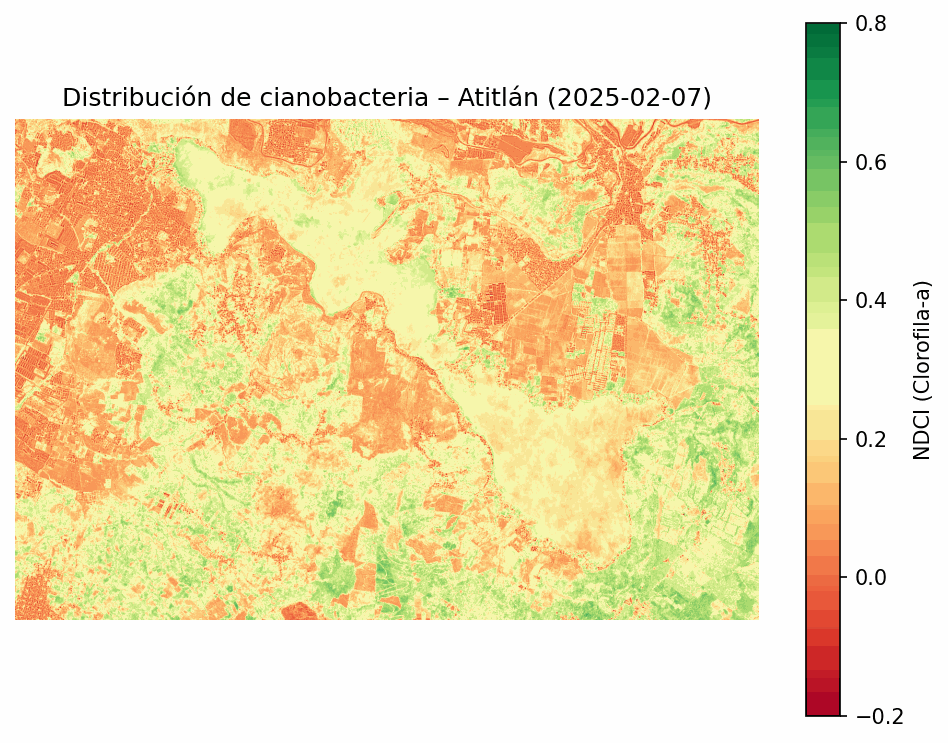

In [165]:
# plot_cyano_distribution("imgs/Bandas_Amatitlan/day_2025-03-04.tiff", "Amatitlán", "2025-03-04")

from PIL import Image
from IPython.display import display, Image as IPImage


# Crear carpeta de salida si no existe
os.makedirs("imgs/Bandas_Amatitlan/figuras", exist_ok=True)

# Generar y guardar cada mapa de cianobacteria
for day in DATES: 
    ruta_amatitlan = f"imgs/Bandas_Amatitlan/day_{day}.tiff"
    plot_cyano_distribution(ruta_amatitlan, "Atitlán", day)  # usa tu función
    plt.savefig(f"imgs/Bandas_Amatitlan/figuras/{day}.png", dpi=150, bbox_inches="tight")
    plt.close()

# Crear lista de imágenes
list_images_Am = [f"imgs/Bandas_Amatitlan/figuras/{day}.png" for day in DATES]
images = [Image.open(path) for path in list_images_Am]

# Guardar como GIF animado
gif_path = "imgs/Bandas_Amatitlan/Amatitlan_cyano.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=300)

display(IPImage(filename=gif_path))

C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2923385816.py:47: RuntimeWarning: divide by zero encountered in divide
  return (b - a) / (b + a)
C:\Users\angel\AppData\Local\Temp\ipykernel_41964\2923385816.py:47: RuntimeWarning: invalid value encountered in divide
  return (b - a) / (b + a)


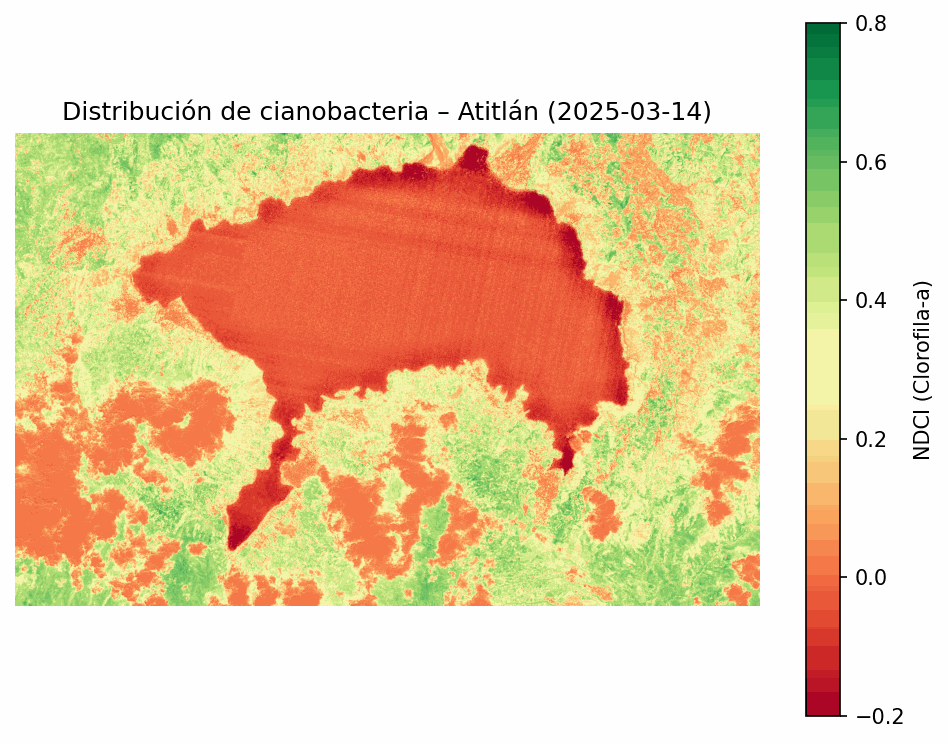

In [168]:

from PIL import Image
from IPython.display import display, Image as IPImage

# plot_cyano_distribution("imgs/Bandas_Atitlan/openEO_2025-03-04Z.tif", "Atitlán", "2025-03-04")

# Crear carpeta de salida si no existe
os.makedirs("imgs/Bandas_Atitlan/figuras", exist_ok=True)

# Generar y guardar cada mapa de cianobacteria
for day in DIAS: 
    ruta_atitlan = f"imgs/Bandas_Atitlan/openEO_{day}Z.tif"
    plot_cyano_distribution(ruta_atitlan, "Atitlán", day)  # usa tu función
    plt.savefig(f"imgs/Bandas_Atitlan/figuras/{day}.png", dpi=150, bbox_inches="tight")
    plt.close()

# Crear lista de imágenes
list_images = [f"imgs/Bandas_Atitlan/figuras/{day}.png" for day in DIAS]
images = [Image.open(path) for path in list_images]

# Guardar como GIF animado
gif_path = "imgs/Bandas_Atitlan/Atitlan_cyano.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=300)

display(IPImage(filename=gif_path))


Al observar ambos gifs, lo principal en el de Atitlan es que tiene valores altos de NDCI 0.4–0.8, colores rojo intenso, en varias fechas, especialmente durante la época cálida que va de marzo a mayo. Esto indica floraciones fuertes y extensas en gran parte del lago.

Mientras, que en Amatitlan se observan valores elevados, pero suelen ser menos homogéneos que en Atitlán. Hay zonas con valores altos y otras con intensidad baja o media. Y la proliferación aparece más localizada en ciertas partes del lago y en este parece que hay varios episodios, peor parecen menos constantes que en Atitlán, porque los intervalos muestran niveles moderados. 

In [ ]:
# !jupyter trust main.ipynb


Signing notebook: main.ipynb


In [139]:
import pandas as pd
import numpy as np

# Dataset vacío
data = []

# Recorremos cada día/lago ya calculado
for key in ndvi.keys():
    # Aplanar arrays (quitando NaNs)
    valid_mask = (
        np.isfinite(ndvi[key]) &
        np.isfinite(ndwi[key]) &
        np.isfinite(ndci[key])
    )
    
    # Extraer valores válidos
    ndvi_vals = ndvi[key][valid_mask].flatten()
    ndwi_vals = ndwi[key][valid_mask].flatten()
    ndci_vals = ndci[key][valid_mask].flatten()
    
    # Guardar en lista
    for v1, v2, v3 in zip(ndvi_vals, ndwi_vals, ndci_vals):
        data.append({
            "NDVI": v1,
            "NDWI": v2,
            "NDCI": v3,
            "LagoDia": key,
            "Lago": key.split(" - ")[0],
            "Fecha": key.split(" - ")[1]
        })

# Convertir a DataFrame
df = pd.DataFrame(data)


In [140]:
# Correlación (todos los días y lagos)
print("Correlación")
print(df[["NDVI", "NDWI", "NDCI"]].corr())

# Correlación por lago
print("\nCorrelación por Lago")
print(df.groupby("Lago")[["NDVI","NDWI","NDCI"]].corr())

# Correlación por día y lago
print("\nCorrelación por día y lago")
for key, df_sub in df.groupby("LagoDia"):
    print(f"\n{key}")
    print(df_sub[["NDVI","NDWI","NDCI"]].corr())


Correlación
          NDVI      NDWI      NDCI
NDVI  1.000000 -0.225351  0.167977
NDWI -0.225351  1.000000 -0.169993
NDCI  0.167977 -0.169993  1.000000

Correlación por Lago
                    NDVI      NDWI      NDCI
Lago                                        
Amatitlan NDVI  1.000000 -0.925242  0.717054
          NDWI -0.925242  1.000000 -0.440626
          NDCI  0.717054 -0.440626  1.000000
Atitlan   NDVI  1.000000 -0.197617  0.153013
          NDWI -0.197617  1.000000 -0.163676
          NDCI  0.153013 -0.163676  1.000000

Correlación por día y lago

Amatitlan - 2025-02-07
          NDVI      NDWI      NDCI
NDVI  1.000000 -0.926187  0.719716
NDWI -0.926187  1.000000 -0.446285
NDCI  0.719716 -0.446285  1.000000

Amatitlan - 2025-02-10
          NDVI      NDWI      NDCI
NDVI  1.000000 -0.926132  0.720158
NDWI -0.926132  1.000000 -0.446947
NDCI  0.720158 -0.446947  1.000000

Amatitlan - 2025-02-25
          NDVI      NDWI      NDCI
NDVI  1.000000 -0.923434  0.718388
NDWI -0.923434  

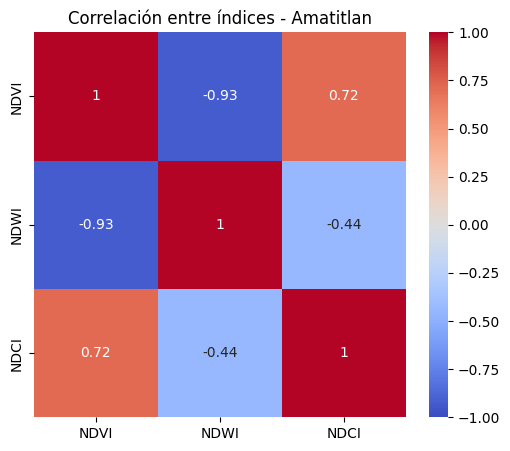

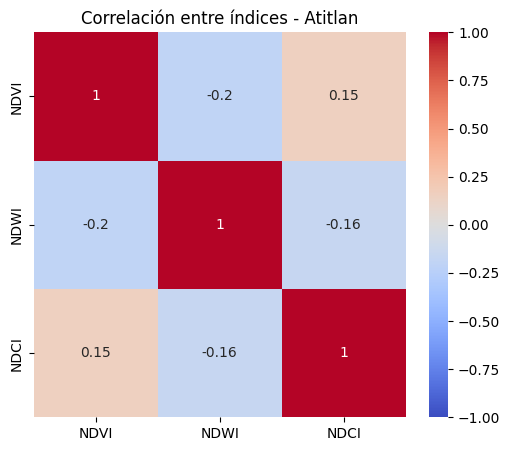

In [143]:
import seaborn as sns

for lago, df_sub in df.groupby("Lago"):
    plt.figure(figsize=(6,5))
    corr = df_sub[["NDVI","NDWI","NDCI"]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Correlación entre índices - {lago}")
    plt.show()


Lo que se puede ver es que en Amatitlán existen correlaciones fuertes, ya que es un lago más pequeño, donde vegetación, agua y cianobacteria están más relacionados.
lo que se ve es que:

- NDVI vs NDWI = -0.93 la correlación negativa muy fuerte.

- NDVI vs NDCI = +0.72 la Correlación positiva fuerte

- NDWI vs NDCI = -0.44 la Correlación negativa moderada.

Mientras que, en Atitlán tiene correlaciones débiles, porque al ser un lago más grande, la cianobacteria es más independiente de los índices NDVI Y NDWI

lo que se ve es que:

- NDVI vs NDWI = -0.20 la Relación negativa débil.

- NDVI vs NDCI = +0.15 la Correlación positiva débil.

- NDWI vs NDCI = -0.16 la También relación muy débil.


c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


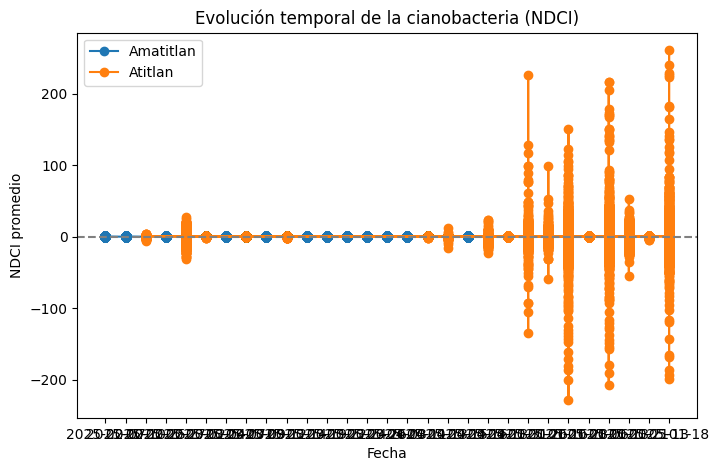

In [144]:
# 9. Análisis de los lagos y comparación entre ellos
# 9.1 análisis de la proliferación de la cianobacteria en el período 
plt.figure(figsize=(8,5))
for lago, dfg in df.groupby("Lago"):
    plt.plot(dfg["Fecha"], dfg["NDCI"], marker="o", label=lago)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Evolución temporal de la cianobacteria (NDCI)")
plt.ylabel("NDCI promedio")
plt.xlabel("Fecha")
plt.legend()
plt.show()

Durante el periodo estudiado lo que se ve es que en Amatitlán, los valores de NDCI se mantiene cercano a 0 durante todo el periodo, lo que indica que tiene una baja proliferación de cianobacterias o que el sensor no detecta floraciones intensas durante el periodo de 6 meses. 

Por otro lado, en Atilán se ven grandes oscilaciones, con valores positivos altos y negativos bajos. Las variaciones implican cambios bruscos en la concentración de clorofila y por lo tanto en la proliferación de cianobacterias. Lo que se ve que supera el umbral de 0.2 o 0.3, que indica periodos de floración intensa.

In [148]:
# 9.2 comparar la floracion

#umbral
umbral = 0.3  
# Marcamos eventos de floración
df["Floracion"] = df["NDCI"] > umbral 

# Resumen por lago
resumen = df.groupby("Lago").agg(
    # número de días con floración
    frecuencia_floraciones = ("Floracion", "sum"),      
    # máxima intensidad alcanzada
    intensidad_max = ("NDCI", "max"),                   
    # promedio solo en días de floración
    intensidad_promedio = ("NDCI", lambda x: x[x>umbral].mean()) 
)
resumen


frecuencia_floraciones  intensidad_max  intensidad_promedio
Lago                                                                  
Amatitlan                 8717989        0.768313             0.390128
Atitlan                  28834860      261.000000             0.511132

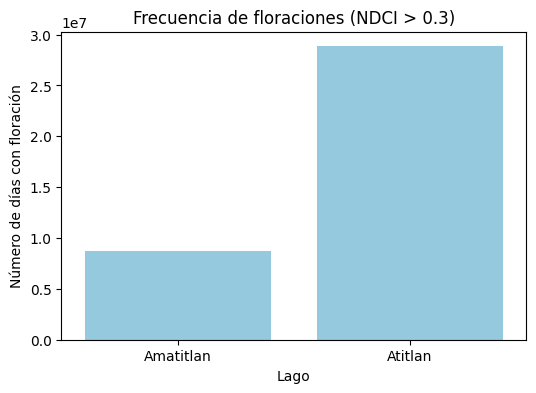

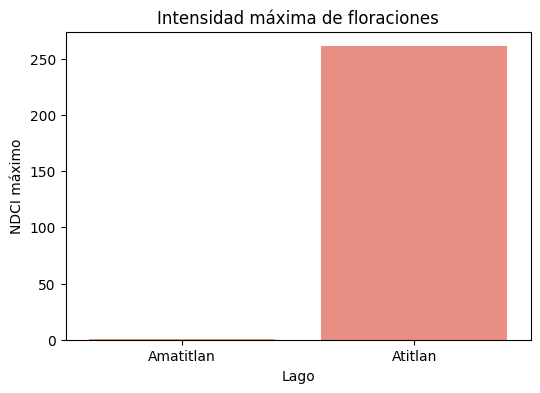

In [149]:
plt.figure(figsize=(6,4))
sns.barplot(data=resumen.reset_index(), x="Lago", y="frecuencia_floraciones", color="skyblue")
plt.title("Frecuencia de floraciones (NDCI > 0.3)")
plt.ylabel("Número de días con floración")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=resumen.reset_index(), x="Lago", y="intensidad_max", color="salmon")
plt.title("Intensidad máxima de floraciones")
plt.ylabel("NDCI máximo")
plt.show()

Lo que se puede ver es que Atitlan tiene más días con floración, al igual que la intensidad máxima alcanzada es bastante mayor que Amatitlán. Acerca de la intensidad promedio, es mayor con una intensidad promedio de 0.511

### Evalúa posibles diferencias con respecto a las causas de la proliferación de la cianobacteria y discútalas (geografía, uso del suelo, presión urbana, temperatura del agua, del ambiente, clima, etc.).

La geografía definitivamente es un factor muy importante, junto a la morfometría del lago. En el caso de Amatitlán es un lago pequeño, con la influencia de la cuenca urbana por parte de Villa Nueva y Guatemala. Lo que también hace que reciba descargas urbanas como las aguas residuales y desechos industriales. Este al tener una profundidad menor, puede favoreces a la mezcla más frecuente, esto oxigena al lago y diluye temporalmente las algas, pero también hace que reciba nutrientes más constantes, lo cual puede explicar porque es que Amátitlan parece quedar estable en cuanto a la proliferación de la cianobacteria. 



Mientras, en Atitlán es un lago más grande y profundo este tiene una capacidad más grande de dilución, pero tiene zonas costeras que son vulnerables en donde se concentran los nutrientes.  Entonces, las zonas que tiene cercanas son las agrícolas y la deforestación de la cuenca, lo que favorece a la erosión y escorrentía de los fertilizantes. Pero por la zona en la que se encuentra, seguramente recibe descargas no tratadas por parte de los turistas. Por otra parte, las cianobacterias prosperan en las aguas cálidas y estratificadas, en este lago la profundidad favorece a la estratificación termica, entonces las zonas superficiales son cálidas con nutrientes acumulados, que nos indican una floración intensa. 

Algo muy importante a tomar en cuenta, es que en el periodo analizado no hubo mucha lluvia, esto es importante porque la lluvia además de oxigenar y darle movimiento al agua esto le da nutrientes a las cuencas. Mientras las sequías y la reducción del caudal de la entrada aumentan la concentración de nutrientes y la temperatura, lo que causa proliferación. Por lo tanto, en los primeros meses del año que no llueve tanto en Guatemala, puede que haya una mayor proliferación. Y Guatemala en el año 2024, tuvo una sequia muy grande lo que afecto bastante al suelo y la acumulación de nutrientes en las cuencas y lagos, ya que los dejó con menos agua, más calor y nutrientes acumulados, lo que las primeras lluvias del 2025 pudo quitar algo de las floraciones más intensas del año pasado. 